<a href="https://colab.research.google.com/github/halah1998/Dysarthria-Classifier/blob/main/k_NN_Classification_(all_data_sets).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from os import system
from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where, random
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 3.7MB/s 


In [27]:
data = pd.read_csv('all_disorders_median_std.csv')

In [28]:
def smote_multiclass(df, num_samples_dict=None, one_hot_encoded=False):
  """
  Performs data augmentation and/or downsampling on a dataframe with multiple classes.
  Supports both numerical and one-hot encoded class values.
  The SMOTE algorithm is used for augmentation and random sampling is used for downsampling of the specified classes.
  Keyword arguments:
  df -- the dataframe to manipulate
  num_samples_dict -- a dictionary of the form {0: num_desired_samples, 1: num_desired_samples, ...} that indicates the
                      number of samples that the returned dataframe should have in each class
  one_hot_encoded -- Boolean value indicating if the dataframe is one-hot encoded
  """

  if df.columns[[0]] == 'Unnamed: 0':
    df.drop(df.columns[[0]], axis=1, inplace=True)  # remove first column

  # change one hot encoded dataset into numerical labels
  if one_hot_encoded:
    df.insert(loc=0, column='Status', value=np.nan)
    for i, row in df.iterrows():
      if df.iloc[i]['Control'] == 1:
          status = 0
      elif df.iloc[i]['Parkinsons'] == 1:
          status = 1
      elif df.iloc[i]['ALS'] == 1:
          status = 2
      elif df.iloc[i]['Cerebral_palsy'] == 1:
          status = 3
      df.at[i,'Status'] = status
    df = df.drop(columns=['Control', 'Parkinsons', 'ALS', 'Cerebral_palsy'])


  if num_samples_dict is not None:
    strategy = num_samples_dict

    # downsampling classes if needed
    counter = Counter(df.Status)
    class_samples = []
    for i in range(4):
      if counter[i] > num_samples_dict[i]: # class i needs to be downsampled
        class_i = df.loc[df['Status'] == i]
        class_i_sample = class_i.sample(n=num_samples_dict[i])
        class_samples.append(class_i_sample)
      else: # class i does not need downsampling
        class_i = df.loc[df['Status'] == i]
        class_samples.append(class_i)

    df = pd.concat(class_samples).reset_index(drop=True)

  else:
    strategy = 'auto'

  y = df.Status # labels
  x = df.drop(['Status', 'Gender'], axis=1) # features only, Gender also removed because it must be binary
  gender = df.Gender

  oversample = SMOTE(sampling_strategy=strategy)
  x_oversampled, y_oversampled = oversample.fit_resample(x, y)

  # get sample counts for augmented dataset
  counter = Counter(y_oversampled)

  if num_samples_dict is not None and (counter[0] != num_samples_dict[0] or counter[1] != num_samples_dict[1]
                                       or counter[2] != num_samples_dict[2] or counter[3] != num_samples_dict[3]):
    print("Sampling failed")
  elif num_samples_dict is None and (counter[0] != counter[1] or counter[1] != counter[2] or counter[2] != counter[3]):
    print("Sampling failed")

  # regenerate dataframe with new samples
  df_concat = pd.concat([pd.DataFrame(y_oversampled), pd.DataFrame(gender), pd.DataFrame(x_oversampled)], axis=1)
  df_concat.columns = df.columns

  # fill missing gender values with a random choice of 0 or 1
  for row in df_concat.loc[df_concat.Gender.isnull(), 'Gender'].index:
    df_concat.at[row, 'Gender'] = random.randint(0, 2)

  # change numerical class values back into one-hot encoded values
  if one_hot_encoded:
    one_hot = pd.get_dummies(df_concat['Status'])
    one_hot.rename(columns={0:'Control', 1:'Parkinsons', 2:'ALS', 3:'Cerebral_palsy'}, inplace=True)
    df_concat = df_concat.drop(columns=['Status'], axis=1)
    df_concat = pd.concat([one_hot, df_concat], axis=1)

  return df_concat, x, y

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


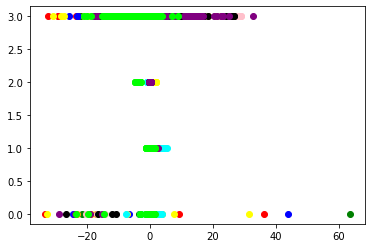

In [55]:
data, x, y = smote_multiclass(data, num_samples_dict={0: 100, 1: 200, 2: 100, 3:200},one_hot_encoded=False)
plt.scatter(x['MDVP:Jitter(%)'],y,color='red')
plt.scatter(x['MDVP:Jitter(Abs)'],y,color='green')
plt.scatter(x['Jitter:PPQ5'],y,color='blue')
plt.scatter(x['Jitter:DDP'],y,color='yellow')
plt.scatter(x['MDVP:Shimmer'],y,color='orange')
plt.scatter(x['MDVP:Shimmer(dB)'],y,color='cyan')
plt.scatter(x['Shimmer:APQ3'],y,color='pink')
plt.scatter(x['Shimmer:APQ5'],y,color='black')
plt.scatter(x['Shimmer:APQ11'],y,color='purple')
plt.scatter(x['DFA'],y,color='lime')
plt.show()

In [56]:
# Fetching the number in each class
count=data.Status.value_counts()
print(count)
print()

'''Splitting Data'''
# Splitting Data into 70% Training data and 30% Testing Data:
X_train, X_Test, y_train,  y_Test = train_test_split(x, y,train_size=0.7, test_size=0.3, random_state=42,stratify=y)
print(f"X_train length is {len(X_train)}.")

#70% Training data and 20% Testing Data and 10% Validation Data
X_test, X_valid, y_test, y_valid = train_test_split(X_Test, y_Test, train_size=0.75,test_size=0.25, random_state=101, stratify=y_Test)
print(f"X_test length is {len(X_test)}.")
print(f"X_valid length is {len(X_valid)}.")
print(f"Y_test length is {len(y_test)}.")

#Seeing the number/percentage of the split
s=np.unique(y_train, return_counts=True)
print()
print(f"The split is as follows:{s}")

#Converting data type for training and testing purposes
import numpy as np
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

3    200
1    200
2    100
0    100
Name: Status, dtype: int64

X_train length is 343.
X_test length is 110.
X_valid length is 37.
Y_test length is 110.

The split is as follows:(array([0, 1, 2, 3]), array([ 70, 140,  70,  63]))


# K-Nearest Neighbor Classification

In [57]:


#k-NN
from sklearn.neighbors import KNeighborsClassifier
#To use the build in multilabel adabtor use:
#from skmultilearn.adapt import MLkNN
#knn_model= MLkNN(k=20)

#fiting training data on model
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn_model.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn_model.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 
    print(train_accuracy[i])
    print(test_accuracy[i])
    score= knn_model.score(X_test,y_test)
    print(f"The fitting score is {score}")

#prediction using K-NN
y_pred = knn_model.predict(X_test)
print(f"The predictions for the data is {y_pred}")

#Looking at accuracy by counting the number of misclassified cases
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in KNN: {}'.format(count_misclassified))

#Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse1 = sqrt(mse)
print(f"Mean square error for training data is {rmse1}")

#evaluating the predictive performance of our model
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse2 = sqrt(mse)
print(f"Mean square error for test data is {rmse2}")

1.0
0.4090909090909091
The fitting score is 0.8272727272727273
0.9271137026239067
0.4090909090909091
The fitting score is 0.7909090909090909
0.9183673469387755
0.4090909090909091
The fitting score is 0.8181818181818182
0.8979591836734694
0.4090909090909091
The fitting score is 0.8272727272727273
0.8892128279883382
0.4090909090909091
The fitting score is 0.8
0.8775510204081632
0.4090909090909091
The fitting score is 0.7818181818181819
0.8629737609329446
0.4090909090909091
The fitting score is 0.7818181818181819
0.8600583090379009
0.4090909090909091
The fitting score is 0.8090909090909091
The predictions for the data is [1. 2. 2. 1. 2. 1. 1. 1. 1. 2. 0. 2. 1. 2. 2. 3. 3. 1. 3. 1. 0. 2. 1. 3.
 1. 3. 1. 2. 3. 3. 2. 0. 1. 3. 1. 1. 1. 3. 0. 2. 1. 3. 0. 1. 2. 3. 1. 1.
 2. 1. 3. 0. 3. 3. 1. 1. 1. 1. 1. 1. 3. 0. 0. 0. 2. 1. 1. 1. 1. 0. 2. 1.
 1. 2. 1. 3. 1. 0. 2. 1. 1. 1. 1. 0. 2. 2. 2. 1. 3. 0. 2. 1. 1. 1. 1. 1.
 1. 3. 2. 2. 1. 1. 1. 1. 0. 0. 1. 1. 3. 1.]
Misclassified samples in KNN: 21
Mean 

# Parameter Tuning & Model Evaluation

In [58]:
#Predicting the best value of k
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 20)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)

#using .best_params_ to find the best performing k
print(f"The best value for k is {gridsearch.best_params_}")

#Seeing how this predicted k affects the training and testing performances
train_preds_grid = gridsearch.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds_grid)
train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
train_rmse

print(f"Mean square error for test data is {test_rmse}")

The best value for k is {'n_neighbors': 3}
Mean square error for test data is 0.4264014327112209


Text(0, 0.5, 'Mean Error')

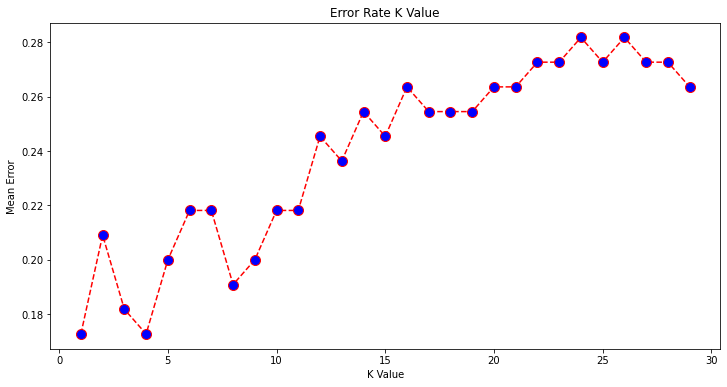

In [59]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
# plot the error values against K values using the elbow graph method
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

[[ 9 14  0  0]
 [ 6 39  0  0]
 [ 0  0 22  0]
 [ 0  0  1 19]]
              precision    recall  f1-score   support

         0.0       0.60      0.39      0.47        23
         1.0       0.74      0.87      0.80        45
         2.0       0.96      1.00      0.98        22
         3.0       1.00      0.95      0.97        20

    accuracy                           0.81       110
   macro avg       0.82      0.80      0.81       110
weighted avg       0.80      0.81      0.80       110



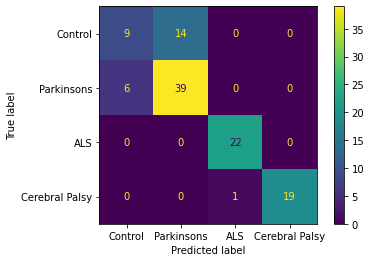

In [60]:
#Evaluating the Algorithm using a confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
y_pred = knn_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Plotting Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn_model, X_test, y_test, display_labels=['Control', 'Parkinsons', 'ALS', 'Cerebral Palsy'])  
plt.show() 

In [62]:
#Loglos Evaluation
from sklearn import model_selection
# log loss (closer to 0 is better)
for k in range(2,20,4):
  kfold = model_selection.KFold(n_splits=k, shuffle=True)
  results = model_selection.cross_val_score(knn_model, x, y, cv=kfold, scoring='neg_log_loss')
  print("Logloss: %.3f (%.f)" % (results.mean(), k))

Logloss: -1.064 (2)
Logloss: -0.750 (6)
Logloss: -0.752 (10)
Logloss: -0.883 (14)
Logloss: -0.813 (18)


In [63]:
#Looking at the ROC of our Model
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
print(f"The False Positive Rate prediction is {fpr}")
print(f"The True Positive Rate prediction is {tpr}")
print(f"The Thresholds are {thresholds}")

The False Positive Rate prediction is [0.         0.21590909 0.22727273 0.82954545 1.        ]
The True Positive Rate prediction is [0. 0. 1. 1. 1.]
The Thresholds are [4. 3. 2. 1. 0.]
